# Dimensionality reduction
Let's recap some of the general techniques we've discussed for building better predictive models:
* Properly validating our models is essential if we want to avoid overfitting and underfitting;
* Increasing dataset size is often the single most effective way to improve performance (when feasible); and,
* Understanding the inductive biases of different regularization methods can help us pick good estimators.

To this toolkit, we now add another broad strategy: picking better features. This is, of course, easier said than done. To a large extent, the process of introducing good features—often referred to as *feature engineering*—is a domain-specific enterprise. This makes it hard to describe general methods for engineering good features: if you don't know anything about personality psychology, for example, you may have trouble deciding which items or scales to include in your surveys.

There is, however, one particular approach to feature set construction that can be approached fairly generically: *dimensionality reduction*. In this section, we'll explore strategies for improving predictions by reducing the size of our feature set in various ways.

As always, we begin with some imports...

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from support import get_features, plot_learning_curves

%matplotlib inline

In [2]:
data = pd.read_csv('data/Johnson-2014-IPIP-300.tsv.gz', sep='\t')

Recall the tension between dataset size and model complexity that's been a recurring theme throughout this tutorial. As we've seen, when we have a limited amount of data, less complex models often outperform more complex ones, because the former are less likely to overfit.

This observation leads directly to another important insight: if we have a feature space that's too big for our model to efficiently learn from, we may be able to reduce the dimensionality of that space until we reach a point that our model is comfortable with. In effect, we're searching for a subspace of our original space that captures most of the reliable variation while shedding most of the noise.

As a toy example, suppose we have a dataset containing three personality scales—the facets of `Vulnerability`, `Anxiety`, and `Excitement-Seeking`. When we inspect the data, we observe that two out of the three scales (`Vulnerability` and `Anxiety`) are strongly correlated:


In [3]:
data[['Anxiety', 'Vulnerability', 'Excitement-Seeking']].corr().round(2)

,Anxiety,Vulnerability,Excitement-Seeking
Anxiety,1.00,0.80,-0.22
Vulnerability,0.80,1.00,-0.11
Excitement-Seeking,-0.22,-0.11,1.00


Or, visually:

In [4]:
from mpl_toolkits.mplot3d import Axes3D
from ipywidgets import interact

anx, vul, exc = get_features(data, 'Anxiety', 'Vulnerability', 'Excitement-Seeking', n=500)
from ipywidgets import interact

def plot_3d_scatter(elev, azim):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(anx, vul, exc, s=20, marker='^')
    ax.set(xlabel='Anxiety', ylabel='Vulnerability', zlabel='Excitement-Seeking')
    ax.view_init(elev, azim);

interact(plot_3d_scatter, elev=45, azim=45);

interactive(children=(IntSlider(value=45, description='elev', max=135, min=-45), IntSlider(value=45, descripti…

When two or more features share variance, it's likely (though by no means guaranteed) that they also share predictively useful variance. Consequently, we may be able to reduce the dimensionality of the feature space, or of some subset of the space, without sacrificing much in the way of predictive power.

Broadly speaking, there are two approaches we could take. First, we could simply select a subset of existing features, without any further manipulation. Second, we could combine some or all of our features to create a smaller number of derivative features.


### Feature selection
We've already seen an implicit example of feature selection when we looked at lasso regression. Recall that the L1 penalty imposed by the lasso has the useful property of shrinking coefficients all the way to zero as we increase the penalty parameter.

While feature selection is built into the lasso, this isn't true of most estimators. But we can make feature selection an explicit step in any preprocessing pipeline. As a simple example, we're always free to use our rational judgment about which features to include. In our toy 3-facet example above, for instance, we could reasonably decide to keep `Anxiety` and discard `Vulnerability`, seeing as the two are very strongly correlated (r = 0.8).

In practice, though, rational feature selection doesn't scale very well, and is a fallible strategy even when we have relatively few features. So we usually rely on algorithmic procedures.

To illustrate, let's use the `SelectKBest` transformer in scikit-learn's `feature_selection` module. `SelectKBest` is a rather simple-minded method: it simply retains the <i>k</i> "best" features, as determined by an arbitrary scoring function. In our case, we'll use the `f_regression` selection function, which simply computes a univariate regression. This means that, in practice, all we're doing is taking our 300 items, correlating each one separately with the target outcome (age), and keeping the *k* items that show the strongest absolute correlation.

We'll also make use of scikit-learn's convenient `Pipeline` class, which allows us to compose a pipeline from an arbitrary sequence of transformers and estimators, and have it behave exactly like a single estimator.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression

pipeline = Pipeline([
    ('feature selection', SelectKBest(f_regression, 30)),
    ('OLS', LinearRegression()),
])

To help us evaluate how much our feature selection step helps improve performance, we'll compare it to both the 30-facet predictor set, and a set of *k* randomly selected items.

In [6]:
items, facets, age = get_features(data, 'items', 'facets', 'AGE')
rand_items = items.sample(30, axis=1)

How well can we predict age using these three different sets of 30 predictors?

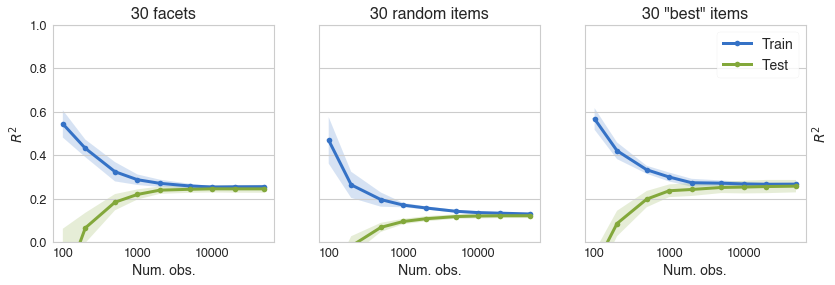

In [7]:
# Note that for the last estimator, we pass in the full set of
# items, because our pipeline includes the feature selection step.
X_sets = [facets, rand_items, items]
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
labels = ['30 facets', '30 random items', '30 "best" items']
estimators = [LinearRegression(), LinearRegression(), pipeline]

plot_learning_curves(estimators, X_sets, age, train_sizes,
                     labels=labels, cv=5, scoring='r2')

The `SelectKBest` step does indeed improve performance non-trivially beyond what we observe for a random selection of items (compare middle and right panels), and is even competitive with the 30-facet set (left).

#####  A note for  the psychometrically minded
A tangential note on the above feature selection procedure: if you've been trained in the psychometric tradition, you might be bothered by the idea that we could haphazardly select the "best" 30 features just by ranking the bivariate correlations. On paper, this strategy seems similar to the much-maligned [stepwise regression](https://en.wikipedia.org/wiki/Stepwise_regression) procedure (a common form of forward sequential feature selection). The typical objection to stepwise regression is that it tends to produce extremely unstable solutions (this is true; as we'll see later, even more sophisticated feature selection methods like lasso regression often select features inconsistently).

Remember, though: we're doing prediction here, not inference! So long as our goal is just to come up with the best possible prediction of the outcome, and not to draw conclusions about why or how our model is making predictions, there's nothing particularly terrible about "dumb" selection procedures like `KBest` or stepwise regression (which, unfortunately, still hasn't [made it into](https://github.com/scikit-learn/scikit-learn/issues/6545) scikit-learn). These procedures may be sub-optimal, but they're not *wrong* in any meaningful sense, because we have no reason to attach any importance to the consistency with which variables are used in our model. And, as you can see above, they're still almost certain to lead to better performance than a *really* naive strategy like simply selecting a random subset of features.

(As an exercise, you can try replacing the `KBest` selection step with recursive feature elimination (`RFE`), which is conceptually similar to stepwise regression, but proceeds in the reverse rather than forward direction. It should result in *much* better performance in this case, but is considerably slower.)

### Feature transformation

Feature selection is helpful when our goal is to reduce the dimensionality of the data without altering the meaning of our features. But if we're not wedded to preserving the same features, we can often do better predictively by *transforming* our raw variables. The intuition here is that, since every variable reflects some combination of signal and noise, if we can aggregate the signal shared by multiple variables in sensible ways, we should end up with composite features that have a higher signal-to-noise ratio than the raw features we started out with.

This insight is not new, of course; it's exactly what motivates researchers [to sum or average items into scales](https://en.wikipedia.org/wiki/Spearman%E2%80%93Brown_prediction_formula). Combining multiple noisy indicators into a single less noisy composite is a powerful dimensionality reduction technique. In a sense, all we're doing here is taking what many scientists have been doing for many decades when using latent variable methods, and situating it specifically in a predictive context.

#### PCA
The most widely used dimensionality reduction technique is principal component analysis (PCA). PCA linearly decomposes a matrix into a set of orthogonal (i.e., uncorrelated) components, where each subsequent component captures as much of the remaining variance in the original matrix as possible. From the standpoint of efficiency (i.e., capturing the maximal amount of variance using the smallest number of components), PCA is optimal: for any fixed number of components <i>k < p</i> (where <i>p</i> is the number of original features), no other linear decomposition method can perform better.

In scikit-learn, using PCA is just as easy as using the other estimators we've encountered. Let's apply it to our toy 3-facet dataset.

In [8]:
from sklearn.decomposition import PCA

pca = PCA()

X = data[['Anxiety', 'Vulnerability', 'Excitement-Seeking']]

pca.fit(X);

Notice that when we fit the PCA, we don't pass in any `y` variable! That's because PCA is an unsupervised learning technique. It's not trying to recapture known labels; it simply identifies the axes of principal variation in our data. Let's visualize them:



In [9]:
from sklearn.preprocessing import scale

# Standardize variables so we don't have to worry about origin
anx, vul, exc = scale(anx), scale(vul), scale(exc)

# basically the same function as earlier, except now we plot
# the principal axes in the original space of the data
def plot_3d_scatter(elev=10, azim=70):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(anx, vul, exc, s=20, marker='^')
    ax.set(xlabel='Anxiety', ylabel='Vulnerability', zlabel='Excitement-Seeking')
    ax.view_init(elev, azim)
    
    # Add principal axes
    axes = (pca.components_.T * pca.explained_variance_).T * 2.5
    for pa in axes:
        ax.plot([0, pa[0]], [0, pa[1]], [0, pa[2]], '-k', lw=3)

interact(plot_3d_scatter, elev=(0, 90), azim=(-180, 180));

interactive(children=(IntSlider(value=10, description='elev', max=90), IntSlider(value=70, description='azim',…

So much for the toy data. Now let's do something a little more useful and apply PCA to all 300 individual personality items.

In [10]:
# For convenience, sklearn lets us can call fit() and transform() in one step
comps = pca.fit_transform(items)

A defining property of PCA is that the $n^{th}$ principal component captures the maximum amount of variance (linearly) possible after accounting for the previous $n-1$ components. In most real-world datasets, where features tend to be at least modestly intercorrelated, this means that the first few components are usually very large relative to the rest. This is almost invariably true of items on personality questionnaires. We can observe this in the *scree plot* of the PCA components extracted from our 300-item matrix:

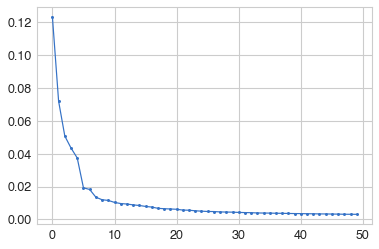

In [11]:
# For visual clarity, plot only the first 50 components
plt.plot(pca.explained_variance_ratio_[:50], 'o-', ms=3);

The drop-off past the first few components is dramatic; the first component alone explains over 12% of the variance in the 300 items!

Another useful way to visualize this information is by plotting the cumulative variance explained:

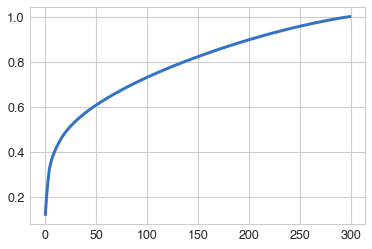

In [12]:
# Cumulative proportion of variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_), lw=3);

#### How many components?
A natural question to ask, given a plot like the one above, is: how many components should we retain? Clearly, diminishing returns set in pretty quickly, but exactly where should we draw the line? Should we keep 5 components or 15?

The short of it is that there's no single correct answer to this question. The "right" number of factors depends on one's goals and practical constraints as much as on any quantitative metric. There are plenty of available methods that purport to tell us how many components, factors or clusters we should keep when doing dimensionality reduction, but there's no particular reason to think that any of them have any great insight into the nature of reality (and in most cases, different metrics will give pretty different answers).

It's best to think of this as a purely pragmatic decision: when we opt to keep 7 rather than 70 components, we're not claiming that *there are only 7 important dimensions underlying the data-generating process*; we're simply saying that, given practical constraints, 7 seems like a reasonable number of components to retain. 

Once we accept that dimensionality reduction methods are almost never suitable for use as causal inference tools, it's very natural to replace the question of what the *right* number of dimensions is with the more tractable question of what number is *useful* in a particular situation (and to a particular person). One benefit of adopting a predictive perspectice (rather than an inferential one) is that quantifying utility can sometimes be straightforward. In the context of our age prediction model, for example, we could simply say that the "optimal" number of PCA components is the one that maximizes $R^2$ in a suitable validation curve:

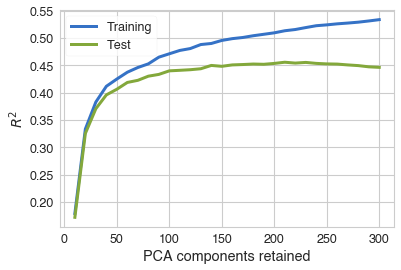

In [13]:
from sklearn.model_selection import validation_curve

# Number of cases
N = 5000

pipeline = Pipeline([
    ('PCA', PCA()),
    ('OLS', LinearRegression())
])

items, age = get_features(data, 'items', 'AGE', n=N)
n_comps = np.arange(10, 310, 10).astype(int)
train_scores, test_scores = validation_curve(pipeline, items, age, 'PCA__n_components', n_comps, cv=5)

plt.plot(n_comps, train_scores.mean(1), lw=3, label='Training')
plt.plot(n_comps, test_scores.mean(1), lw=3, label='Test')
plt.xlabel("PCA components retained")
plt.ylabel("$R^2$")
plt.legend();

In this case, we might decide to keep somewhere between 50 - 100 components.

One thing this kind of approach highlights is that the optimal number of PCA components is always data-dependent. The bias-variance tradeoff still applies: the larger our dataset, the more we'll benefit from using a high-variance, low-bias estimator (i.e., one that has more predictors to work with). We can verify this empirically by re-running the above cell with different values of `N`. At a certain point, if our sample is big enough, there will be no benefit at all to using a linear dimensionality reduction method like PCA (at least from the standpoint of test error minimization).

As a last step, we can compare age prediction accuracy when using PCA components instead of raw items. The whole motivation for using PCA to dimensionality reduce our feature set was to improve predictive performance, so let's verify that this is in fact what happens...

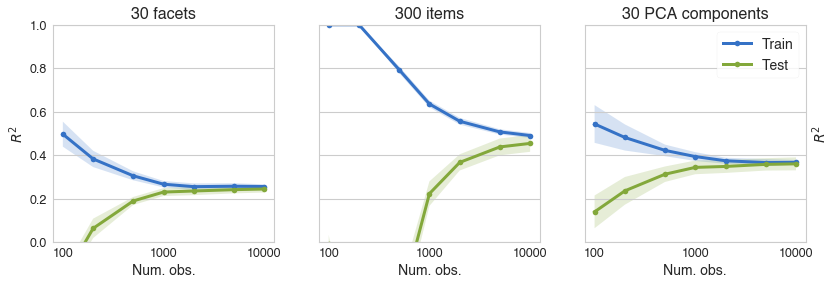

In [14]:
# make sure we use the same sample size for all sets
items, facets, age = get_features(data, 'items', 'facets', 'AGE')

# 30 PCA components, to put on level footing with the 30 facets
pca_comps = PCA(30).fit_transform(items)

X_sets = [facets, items, pca_comps]
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]
labels = ['30 facets', '300 items', '30 PCA components']
plot_learning_curves(LinearRegression(), X_sets, age, train_sizes,
                        labels=labels, cv=5, scoring='r2')

What we see above is a pretty typical pattern of results: for any fixed number of features, PCA components almost always outperform the raw features they were derived from (though this is *not* guaranteed). In this case, the first 30 PCA components derived from the 300 items explain around 38% of the variance in chronological age—substantially more than the ~27% explained by the 30 personality facets (and remember that the facets are already themselves already dimensionally-reduced representations of the full item pool, so technically this comparison is actually biased against the PCA components!). The PCA-based model still doesn't do as well as the 300-item model once the sample gets very large, which, as noted above, is to be expected.

### Other methods
PCA is a dimensionality reduction workhorse, and so long as our goal is strictly to optimize prediction accuracy using linear methods, there's really no reason to use any other method. Often, however, predictive accuracy is not the only consideration. For example, in much the same way that we might opt for lasso regression over ridge regression because we value sparsity, we might also want a dimensionality reduction method that produces sparse (and hence seemingly more interpretable) components. Scikit-learn provides us with a [sparse PCA](https://en.wikipedia.org/wiki/Sparse_PCA) estimator that imposes a sparsity constraint on PCA. If we value sparsity enough, and the hit to predictive accuracy isn't too big, we might be willing to make the trade.

To illustrate, let's compare learning curves for our age prediction models when using three different sets of predictors: (a) the 30 facets, (b) 30 PCA components, and (c) 30 sparse PCA components (with the penalty parameter set fairly high).

/Users/tal/miniconda3/envs/base/lib/python3.6/site-packages/sklearn/decomposition/sparse_pca.py:388: DeprecationWarning: normalize_components=False is a backward-compatible setting that implements a non-standard definition of sparse PCA. This compatibility mode will be removed in 0.22.
  DeprecationWarning)


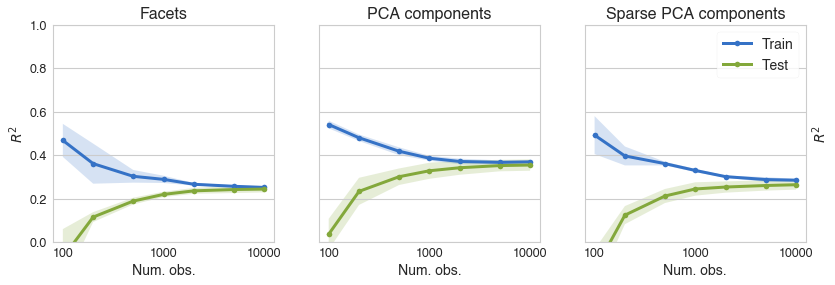

In [15]:
from sklearn.decomposition import MiniBatchSparsePCA

items, age = get_features(data, 'items', 'AGE')

pca_comps = pca.fit_transform(items)

# Extract components with sparse PCA. Note the high penalty, which will
# produce a relatively sparse solution--likely at a heavy predictive cost
spca = MiniBatchSparsePCA(30, alpha=10)
spca_comps = spca.fit_transform(items)

# Plot comparison
X_sets = [facets, pca_comps[:, :30], spca_comps]

# Limit to n=10000 for speed
train_sizes = [100, 200, 500, 1000, 2000, 5000, 10000]
labels = ['Facets', 'PCA components', 'Sparse PCA components']
plot_learning_curves(LinearRegression(), X_sets, age, train_sizes,
                        labels=labels, cv=5, scoring='r2')

In this case, the components extracted with PCA appear to be much less useful predictively than those extracted with PCA. But we might still prefer the former if we care a lot about having a sparse mapping from components to items. Let's take a look at the loading matrices:

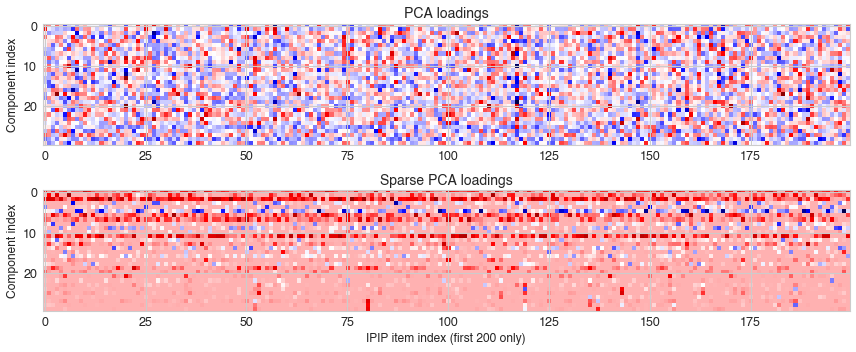

In [16]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5))

# Loadings of first 200 items on first 30 PCA components 
axes[0].imshow(pca.components_[30:0:-1, :200], cmap='seismic');
axes[0].set_title("PCA loadings", fontsize=14)
axes[0].set_ylabel("Component index", fontsize=12)

# Loadings of first 200 items on 30 SPCA components 
axes[1].imshow(spca.components_[::-1, :200], cmap='seismic')
axes[1].set_title("Sparse PCA loadings", fontsize=14);
axes[1].set_xlabel("IPIP item index (first 200 only)", fontsize=12)
axes[1].set_ylabel("Component index", fontsize=12)

plt.tight_layout()